## Prueba

In [1]:
import pickle
from pprint import pprint
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dcss.text import bigram_process, preprocess, bow_to_df
from dcss.plotting import format_axes_commas, custom_seaborn
from dcss.utils import sparse_groupby
custom_seaborn()
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import scipy

In [4]:
columns = ['speech', 'speakername', 'party', 'constituency', 'year']
uk_df = pd.read_csv("data/hansard-speeches-v301.csv", usecols= columns)
uk_df.dropna(subset=['party', 'speakername', 'speech'], inplace=True)
uk_df = uk_df.query('year > 2016')
uk_df['party'].value_counts()

Conservative                         1875
Scottish National Party              1768
Liberal Democrat                     1759
Labour                               1542
Democratic Unionist Party             961
Independent                           483
Labour (Co-op)                        341
Plaid Cymru                           247
Green Party                            96
The Independent Group for Change       39
Social Democratic & Labour Party       37
Ulster Unionist Party                  29
Change UK - The Independent Group      28
UK Independence Party                   3
Alliance                                1
Name: party, dtype: int64

In [5]:
parties_keep = [
    'Conservative',
    'Labour',
    'Scottish National Party',
    'Labour (Co-op)',
    'Liberal Democrat',
    'Democratic Unionist Party',
    'Plaid Cymru',
    'Green Party'
]
party_subset = uk_df[uk_df['party'].isin(parties_keep)].copy()
party_subset.reset_index(drop=True, inplace=True)
total_speech_counts = party_subset['party'].value_counts()
total_speech_counts

Conservative                 1875
Scottish National Party      1768
Liberal Democrat             1759
Labour                       1542
Democratic Unionist Party     961
Labour (Co-op)                341
Plaid Cymru                   247
Green Party                    96
Name: party, dtype: int64

In [6]:
sampled_speeches = party_subset.groupby('party').sample(replace=False, frac=.3, random_state=23)
len(sampled_speeches)

2576

In [12]:
with open('data/pickles/sampled_british_hansard_speeches.pkl', 'wb') as fp:
    pickle.dump(sampled_speeches, fp)
sampled_speech_counts = sampled_speeches['party'].value_counts()
sample_sizes = pd.DataFrame(zip(total_speech_counts,
sampled_speech_counts),
columns=['Total', 'Sample'],
index=parties_keep)

In [13]:
sampled_speeches['speech_len'] = sampled_speeches['speech'].apply(lambda x: len(x.split(" ")))

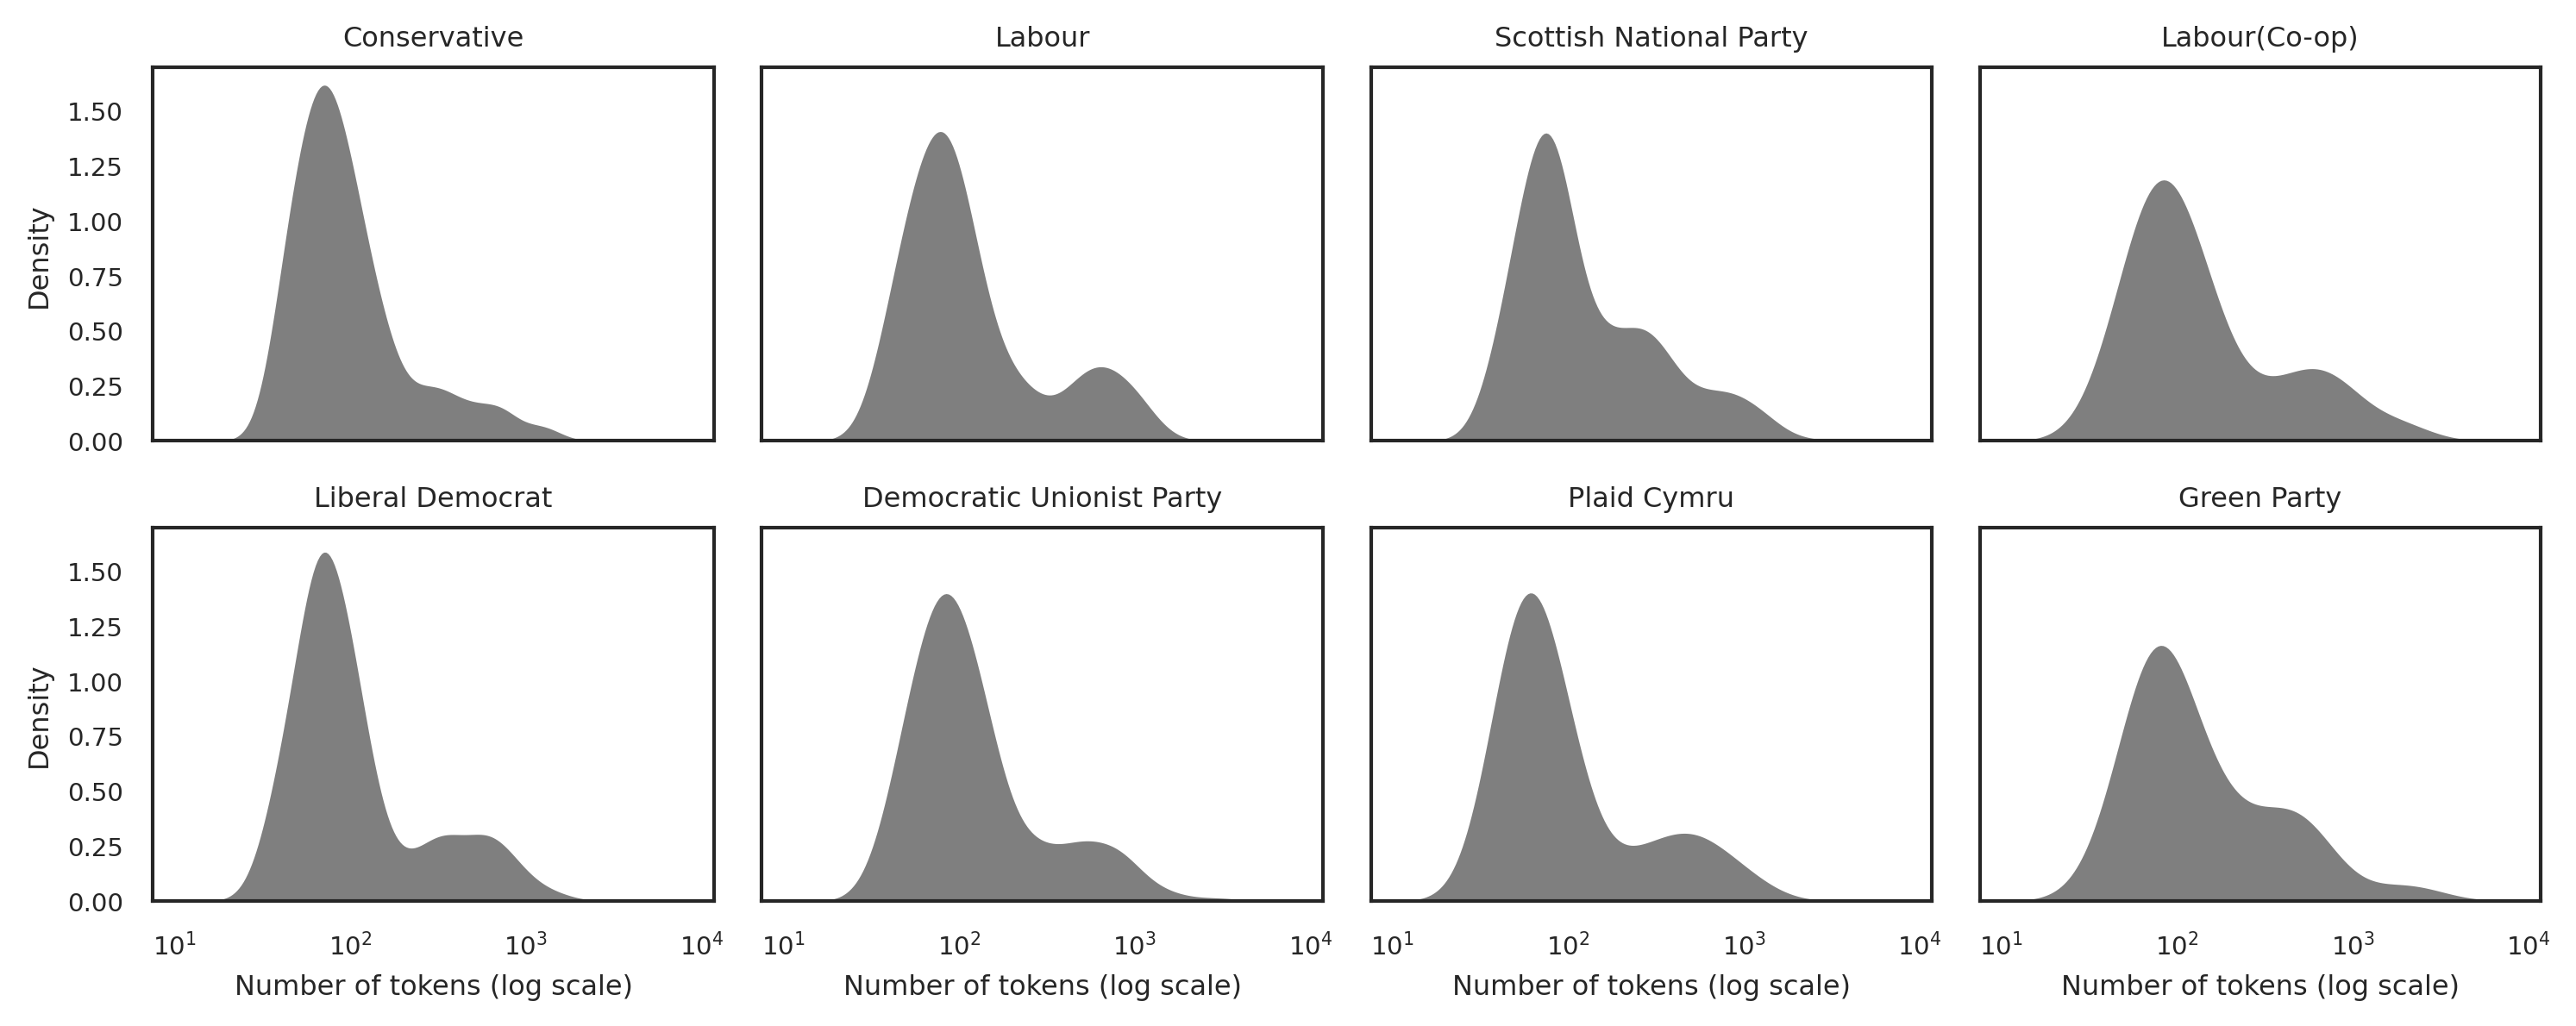

In [15]:
parties = sampled_speeches.groupby('party')
def party_subplot(subgroup, title, position):
    sns.kdeplot(ax = position, data=subgroup, x='speech_len', log_scale=True, fill=True, alpha=.5, linewidth=0, color='black') 
    position.set(xlabel='Number of tokens (log scale)', title=title)
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 4))
    
party_subplot(parties.get_group('Conservative'), 'Conservative', ax[0,0])
party_subplot(parties.get_group('Labour'), 'Labour', ax[0,1])
party_subplot(parties.get_group('Scottish National Party'), 'Scottish National Party', ax[0,2])
party_subplot(parties.get_group('Labour (Co-op)'), 'Labour(Co-op)', ax[0,3])
party_subplot(parties.get_group('Liberal Democrat'),'Liberal Democrat', ax[1,0])
party_subplot(parties.get_group('Democratic Unionist Party'), 'Democratic Unionist Party', ax[1,1])
party_subplot(parties.get_group('Plaid Cymru'), 'Plaid Cymru', ax[1,2])
party_subplot(parties.get_group('Green Party'), 'Green Party', ax[1,3])

plt.tight_layout()
plt.show()

In [16]:
parties['speech_len'].median()

party
Conservative                  82.0
Democratic Unionist Party     99.0
Green Party                   91.0
Labour                        91.0
Labour (Co-op)               105.0
Liberal Democrat              83.0
Plaid Cymru                   69.0
Scottish National Party       93.0
Name: speech_len, dtype: float64

In [21]:
bigram_model, prepocessed = preprocess(sampled_speeches['speech'], nlp=nlp, bigrams=True, detokenize=True, n_process=4)
len(prepocessed)

2576

In [30]:
with open('data/pickles/processed_sample_british_party_subset_hansards.pkl', 'wb') as fp: 
    pickle.dump(prepocessed, fp)
with open('data/pickles/sample_british_party_subset_hansard_bigram_model.pkl', 'wb') as fp: 
    pickle.dump(bigram_model, fp)
with open('data/pickles/processed_sample_british_party_subset_hansards.pkl', 'rb') as fp:
    preprocessed = pickle.load(fp)


In [31]:
sampled_speeches.iloc[700]['speech']

'May I remind the Leader of the House that the outcome of the England-Ireland match could mean a great deal in respect of the confidence and supply motion?  [Laughter.] I jest, of course.Let me now raise a very serious matter. Last weekend, during Sunday mass, a Roman Catholic cathedral in the Philippines was struck by horror and tragedy when two bombs exploded, killing at least 20 people and wounding more than 100. Responsibility for that devastating attack, which killed both civilians and some police officers who were trying to protect them, was claimed by Daesh.Across the world, terrorists are picking on, attacking and killing those who are worshipping their God in their place of worship. Will the Leader of the House agree to arrange a statement or a debate on this ongoing and global terrorist violence?'

In [32]:
sampled_speeches['preprocessed'] = preprocessed
sampled_speeches.iloc[700]['preprocessed']

'leader house outcome england ireland match great deal respect confidence supply motion laughter course matter weekend sunday mass roman_catholic cathedral philippine horror tragedy bomb people responsibility devastating attack civilian police officer daesh world terrorist god place worship leader house statement debate ongoing global terrorist violence'

In [33]:
count_vectorizer = CountVectorizer(max_df=.1, min_df=3, strip_accents='ascii')

In [34]:
count_matrix = count_vectorizer.fit_transform(preprocessed)
vocabulary = count_vectorizer.get_feature_names_out()
count_matrix.shape

(2576, 3713)

In [35]:
with open('data/pickles/brit_hansards_sample_party_subset_count_matrix.pkl', 'wb') as fp:
    pickle.dump(count_matrix, fp)
with open('data/pickles/brit_hansards_sample_party_subset_vocabulary.pkl', 'wb') as fp:
    pickle.dump(vocabulary, fp)

In [36]:
count_data = pd.DataFrame.sparse.from_spmatrix(count_matrix)
count_data.columns = vocabulary
count_data.index = sampled_speeches['party']
count_data.shape

(2576, 3713)

In [37]:
print('sparse size: ' + str(count_data.memory_usage().sum()/1048576) + "MB")
print('sparse density : ' + str(count_data.sparse.density))

sparse size: 0.8612747192382812MB
sparse density : 0.007688907364254851


In [38]:
count_data_d = count_data.sparse.to_dense()
print('dense size: ' + str(count_data_d.memory_usage().sum()/1048576) + "MB")

dense size: 72.992431640625MB


In [39]:
party_counts = sparse_groupby(sampled_speeches['party'], count_matrix, vocabulary)
results = party_counts.div(party_counts.sum(axis=1), axis=0)
results_t = results.T
results_t.sample(20, random_state=10061986)

                Conservative  ...  Scottish National Party
theresa             0.000000  ...                 0.000087
disaster            0.000057  ...                 0.000218
integral            0.000227  ...                 0.000044
cannabis            0.000455  ...                 0.000218
stark_contrast      0.000057  ...                 0.000087
direction           0.000739  ...                 0.000348
erskine             0.000114  ...                 0.000087
minor               0.000000  ...                 0.000131
interface           0.000057  ...                 0.000044
gulf                0.000057  ...                 0.000000
graduate            0.000114  ...                 0.000000
close               0.000682  ...                 0.000783
day                 0.002047  ...                 0.003960
southern            0.000057  ...                 0.000044
vulnerability       0.000057  ...                 0.000044
forefront           0.000114  ...                 0.0000

In [40]:
search_term = 'scotland'

In [41]:
results_t.loc[search_term].sort_values(ascending=False)

Scottish National Party      0.015622
Plaid Cymru                  0.002283
Liberal Democrat             0.001804
Conservative                 0.001592
Democratic Unionist Party    0.001381
Labour (Co-op)               0.000899
Labour                       0.000678
Green Party                  0.000000
Name: scotland, dtype: float64

In [42]:
n_top_words = 5
top_words_per_party = {}

In [43]:
for party in results_t.columns:
    top = results_t[party].nlargest(n_top_words)
    top_words_per_party[party] = list(zip(top.index, top))
for k, v in top_words_per_party.items():
    print(k.upper())
    for each in v:
        print(each)
    print('\n')

CONSERVATIVE
('school', 0.006653019447287615)
('business', 0.006368702376890708)
('child', 0.006084385306493802)
('lady', 0.005174570681223701)
('local', 0.005174570681223701)


DEMOCRATIC UNIONIST PARTY
('northern_ireland', 0.025021570319240724)
('united_kingdom', 0.007333908541846419)
('assembly', 0.006125970664365833)
('decision', 0.0060396893874029335)
('matter', 0.005004314063848145)


GREEN PARTY
('climate', 0.00954328561690525)
('law', 0.00954328561690525)
('action', 0.008861622358554875)
('group', 0.008861622358554875)
('system', 0.008861622358554875)


LABOUR
('amendment', 0.006672922531539985)
('child', 0.0059430716296528)
('day', 0.005630278385986863)
('labour', 0.004639766447711396)
('family', 0.00458763424043374)


LABOUR (CO-OP)
('young', 0.009713977334052886)
('committee', 0.007375427235114229)
('health', 0.007015650296815974)
('legislation', 0.006835761827666847)
('community', 0.0061162079510703364)


LIBERAL DEMOCRAT
('child', 0.0069518149012948414)
('home', 0.00541286

In [44]:
diff_con_snp = results_t['Conservative'] - results_t['Scottish National Party']
diff_con_snp.sort_values(ascending=False, inplace=True)
con_not_snp = diff_con_snp.head(20) # Conservatives but not SNP
con_not_snp

school         0.005478
lady           0.004000
local          0.003260
education      0.002699
business       0.002496
police         0.002405
high           0.002377
opportunity    0.002337
council        0.002316
child          0.002081
fire           0.002040
department     0.002012
great          0.001902
safety         0.001823
challenge      0.001799
building       0.001559
support        0.001493
transport      0.001478
labour         0.001470
pupil          0.001448
dtype: float64

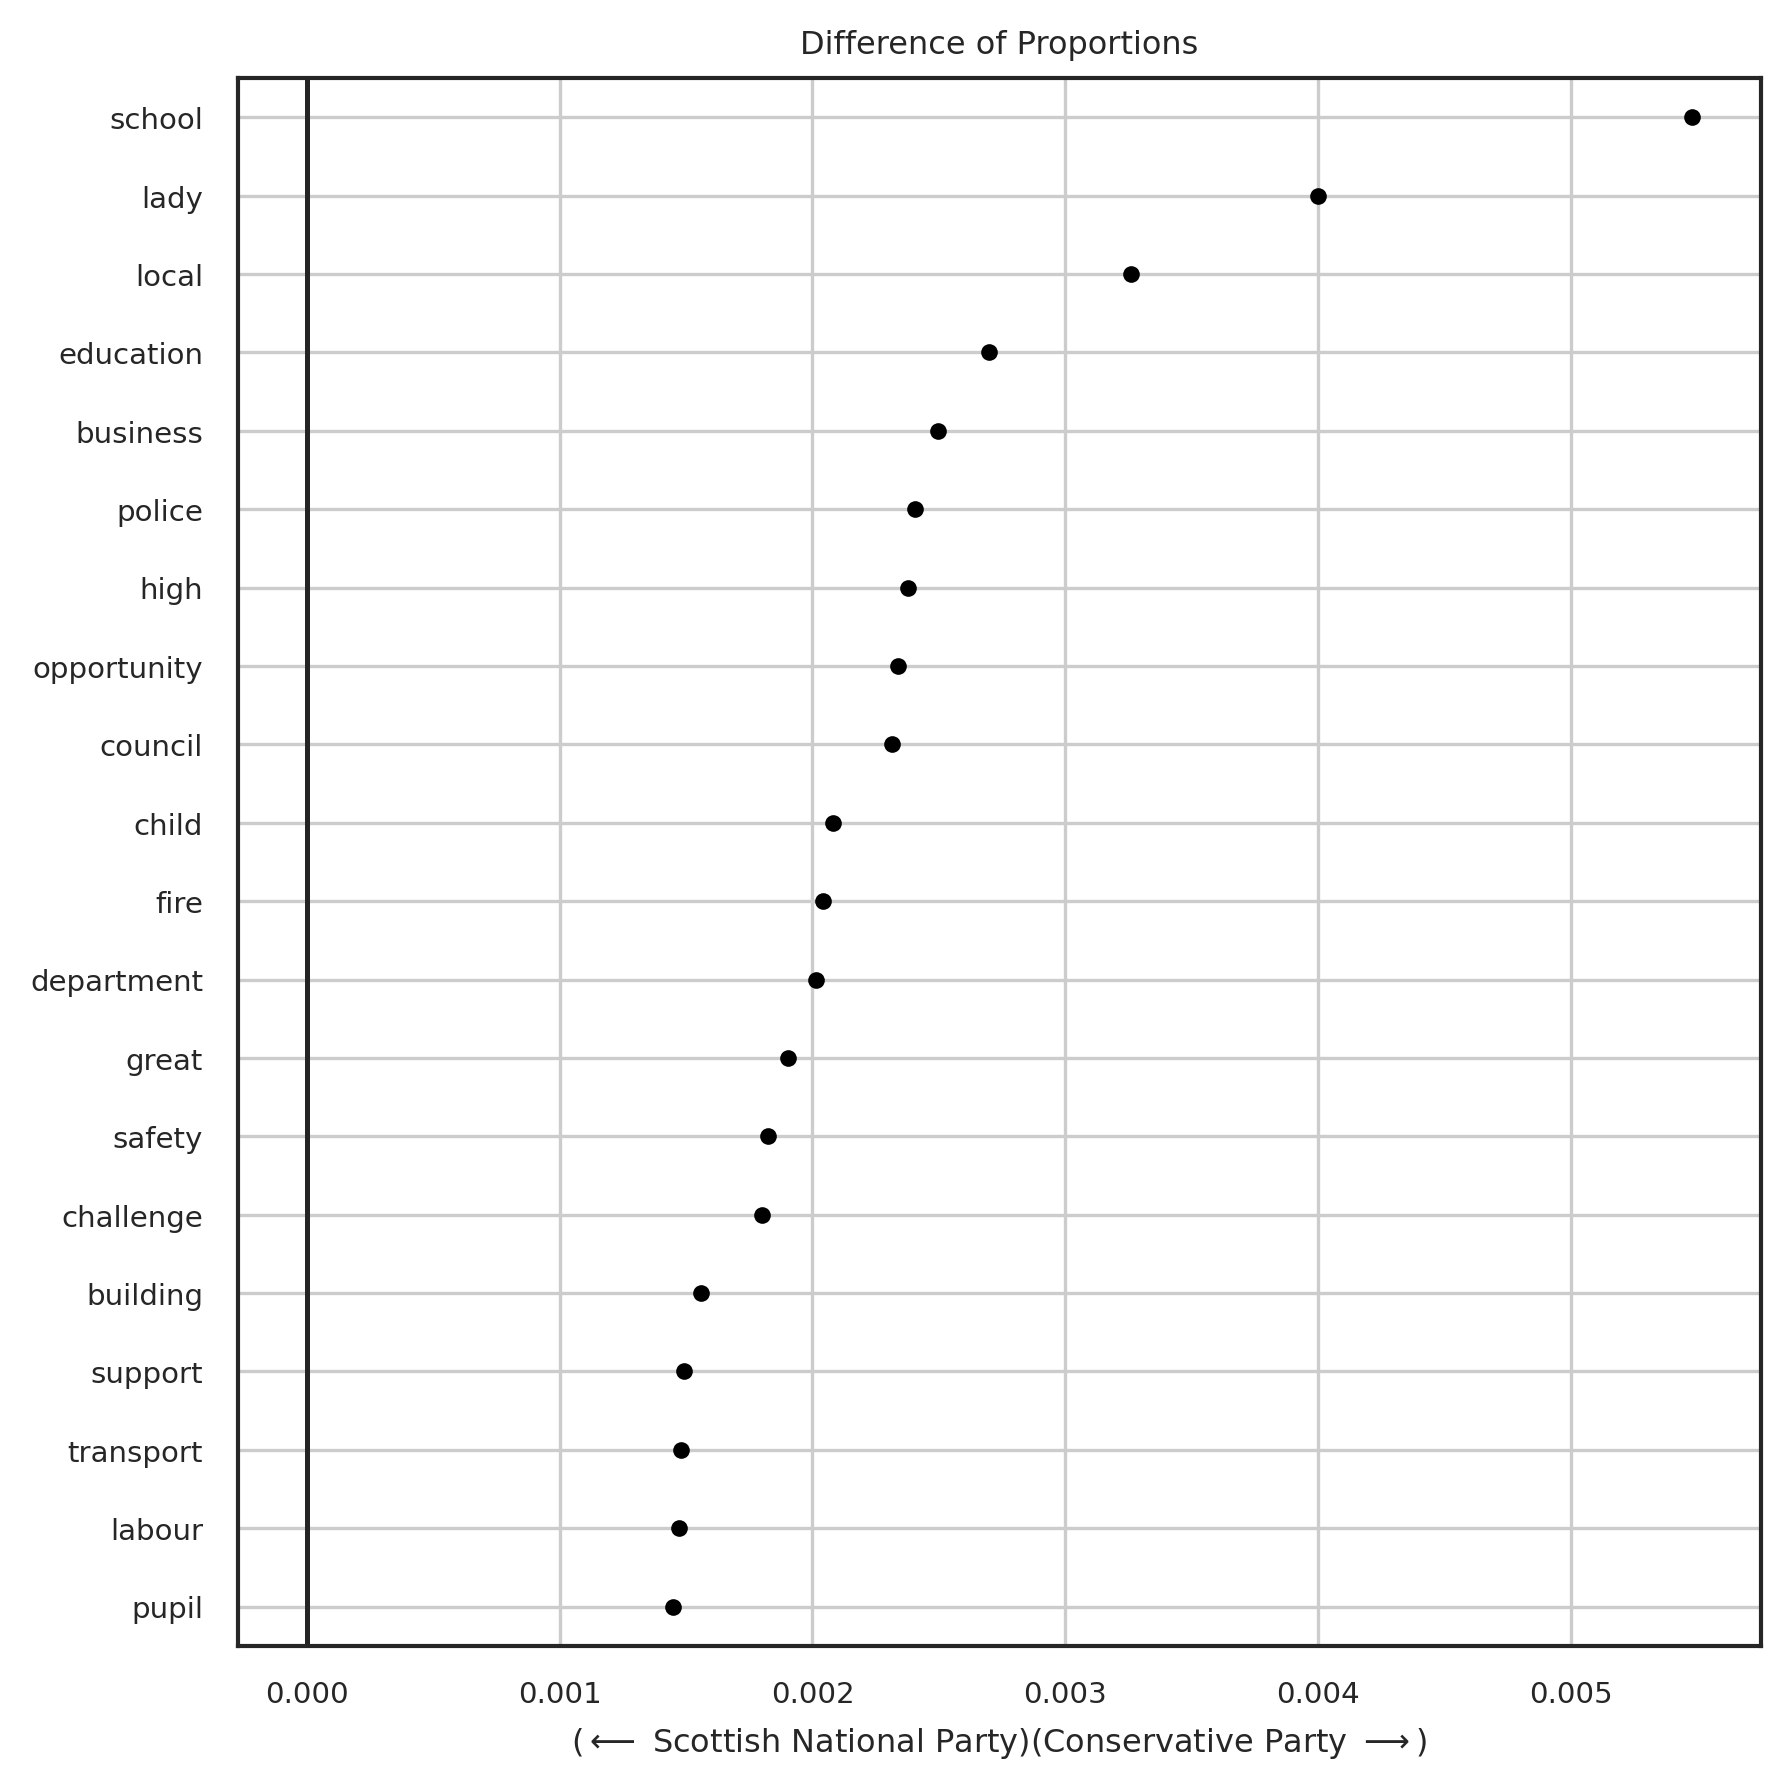

In [48]:
dop = pd.concat([con_not_snp])
fig, ax = plt.subplots(figsize=(6, 6))
sns.swarmplot(x=dop, y=dop.index, color='black', size=4)
ax.axvline(0) # add a vertical line at 0
plt.grid() # add a grid to the plot to make it easier to interpret
ax.set(xlabel=r'($\longleftarrow$ Scottish National Party)(Conservative Party $\longrightarrow$)', ylabel='', title='Difference of Proportions')
plt.tight_layout()
plt.show()